In [2]:
# import tensorflow as tf
# print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import tempfile

In [3]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random


# Parameters
WINDOW_SIZE = 300
STEP_SIZE = 275
TOLERANCE = 0.1
MAX = 20000
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
LABELS = []
X = []
y = []
well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
                'Computer','Electric Heater','Hi-Fi','Overhead Fan']


In [ ]:

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def process_file(file_path, label_idx):
    print(f"Processing file: {file_path}")
    df = pd.read_csv(file_path)
    with open(file_path) as f:
        appliance_name = f.readline().strip().split(",")[1]

    if appliance_name not in df.columns:
        return []

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    return [(window, label_idx) for window in extract_windows(signal)]

def load_balanced_dataset(data_dir, well_represented=well_represented):
    global LABELS, X, y

    label_map = {name: i for i, name in enumerate(well_represented)}
    all_windows = {label: [] for label in well_represented}

    # Step 1: Load all data first
    for class_dir in sorted(Path(data_dir).iterdir()):
        if not class_dir.is_dir():
            continue
        class_name = class_dir.name
        if class_name not in well_represented:
            continue
        label_idx = label_map[class_name]
        if class_name not in LABELS:
            LABELS.append(class_name)
        for file in class_dir.glob("*.csv"):
            windows = process_file(file, label_idx)
            all_windows[class_name].extend(windows)

    # Step 2: Select reference class and determine target range
    ref_class = random.choice(well_represented)
    original_ref_count = len(all_windows[ref_class])
    ref_count = min(MAX, original_ref_count)
    print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

    min_required = int(ref_count * (1 - TOLERANCE))
    max_allowed = int(ref_count * (1 + TOLERANCE))
    cap = min(MAX, max_allowed)


    # Step 3: Apply sampling per class
    for label in well_represented:
        class_windows = all_windows[label]
        # needed = random.randint(min_required, cap)
        needed = MAX

        if len(class_windows) >= needed:
            chosen = random.sample(class_windows, needed)
        else:
            repeat_count = (needed // len(class_windows)) + 1
            extended = class_windows * repeat_count
            chosen = extended[:needed]
            chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                      for (w, lbl) in chosen]

        for window, label_idx in chosen:
            X.append(window)
            y.append(label_idx)

        print(f"{label}: {len(chosen)} samples")

    print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
    for label in well_represented:
        print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

    X_np = np.array(X)[..., np.newaxis]
    y_np = to_categorical(y, num_classes=len(LABELS))
    return X_np, y_np


X, y = load_balanced_dataset(DATA_DIR)

Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Pr

In [6]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 12105 samples
Dishwasher          : 11943 samples
Electric Heater     : 12059 samples
Freezer             : 11983 samples
Fridge              : 12088 samples
Hi-Fi               : 11970 samples
Kettle              : 11951 samples
Microwave           : 12111 samples
Overhead Fan        : 11923 samples
Toaster             : 11999 samples
Tumble Dryer        : 11957 samples
Washer Dryer        : 11949 samples
Washing Machine     : 11962 samples

Class distribution in VALIDATION set:
Computer            : 5552 samples
Dishwasher          : 5672 samples
Electric Heater     : 5560 samples
Freezer             : 5646 samples
Fridge              : 5490 samples
Hi-Fi               : 5614 samples
Kettle              : 5627 samples
Microwave           : 5495 samples
Overhead Fan        : 5654 samples
Toaster             : 5613 samples
Tumble Dryer        : 5649 samples
Washer Dryer        : 5644 samples
Washing Machine     : 5584 samples

Cla

In [5]:
from keras.layers import Activation, Multiply, Add
from keras.utils import get_custom_objects
from keras.activations import relu

def relu6_div6(x):
    return relu(x, max_value=6) / 6

get_custom_objects().update({'relu6_div6': Activation(relu6_div6)})

def Conv1DGLUBlock(filters, kernel_size):
    def block(x):
        linear = Conv1D(filters, kernel_size, padding='same')(x)
        gate = Conv1D(filters, kernel_size, padding='same')(x)
        gate_out = Activation(relu6_div6)(gate)
        return Multiply()([linear, gate_out])
    return block

def ResidualBlock(filters, kernel_size):
    def block(x):
        out = Conv1DGLUBlock(filters, kernel_size)(x)
        out = Conv1D(filters, kernel_size=1, padding='same')(out)
        if x.shape[-1] != out.shape[-1]:
            x = Conv1D(filters, kernel_size=1, padding='same')(x)  # 1x1 conv to match channels
        return Add()([x, out])
    return block

In [ ]:
# from Conv1D_GLU import Conv1DGLU
# from ResidualBlock import ResidualBlock
from keras.models import Model
from keras.layers import Add

def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")

    # x = Conv1DGLU(filters=64, kernel_size=5)(input_layer)
    x = ResidualBlock(filters=64, kernel_size=5)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    # input_layer = x  # Save the input for residual connection
    # x2 = Conv1DGLU(filters=128, kernel_size=3)(x)
    x = ResidualBlock(filters=128, kernel_size=3)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [5]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [114]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Input shape: (None, 300, 1)
Input shape: (None, 150, 64)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 75, 128)   │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,320 │ lstm_13[0][0]   

 Total params: 138,701 (541.80 KB)

 Trainable params: 138,701 (541.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 80ms/step - accuracy: 0.3831 - loss: 1.6085 - val_accuracy: 0.5754 - val_loss: 1.1115
Epoch 2/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 218s 89ms/step - accuracy: 0.5968 - loss: 1.0672 - val_accuracy: 0.7507 - val_loss: 0.6808
Epoch 3/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 198s 81ms/step - accuracy: 0.7068 - loss: 0.8023 - val_accuracy: 0.7393 - val_loss: 0.6531
Epoch 4/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 82ms/step - accuracy: 0.7467 - loss: 0.6835 - val_accuracy: 0.7954 - val_loss: 0.5785
Epoch 5/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 206s 84ms/step - accuracy: 0.7791 - loss: 0.5828 - val_accuracy: 0.7992 - val_loss: 0.5360
Epoch 6/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 208s 85ms/step - accuracy: 0.7953 - loss: 0.5403 - val_accuracy: 0.8439 - val_loss: 0.4225
Epoch 7/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 199s 81ms/step - accuracy: 0.8292 - loss: 0.4639 - val_accuracy: 0.8550 - val_loss: 0.3860
Epoch 8/10
2438/2438 ━━━━━━━━━━━━━━━━━━━━ 207s 85ms/step - accuracy: 

In [115]:
from sklearn.metrics import accuracy_score

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
test_accuracy = accuracy_score(y_true, probs)
print("Test Accuracy:", test_accuracy)

975/975 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step
Test Accuracy: 0.8754487179487179


In [116]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues,
                          figsize=(12, 10),
                          fontsize=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize+2)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.show()


Confusion matrix, without normalization
[[1783  209    1    0    0    1  291    0    0   41    0   16    1]
 [ 194 1994    0    2    0    0  183    0    0    8    0    4    0]
 [   1    0 2315    5    4   31    2    2    3    7    8    0    3]
 [   0    0    8 2313    0    1    0    0    0   13   27    0    9]
 [   0    0   39   29 2295    0    0    0    6   11   30    0   12]
 [   0    0 1028    3    0 1341    0    0    0    1   43    0    0]
 [  13   13    0    0    0    1 2156    0    0  150    1   88    0]
 [   0    0    0    0    0    0    0 2394    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0 2418    0    0    0    5]
 [  85    8    1    1    1    1  102    0   10 2061    0  118    0]
 [   0    0  580    3    7   33    0    0   54    0 1593    0  124]
 [   1    0    0    0    0    0    1    0   10  113    0 2280    2]
 [   0    0    0    0    0    0    0    0   71   12    0    0 2371]]


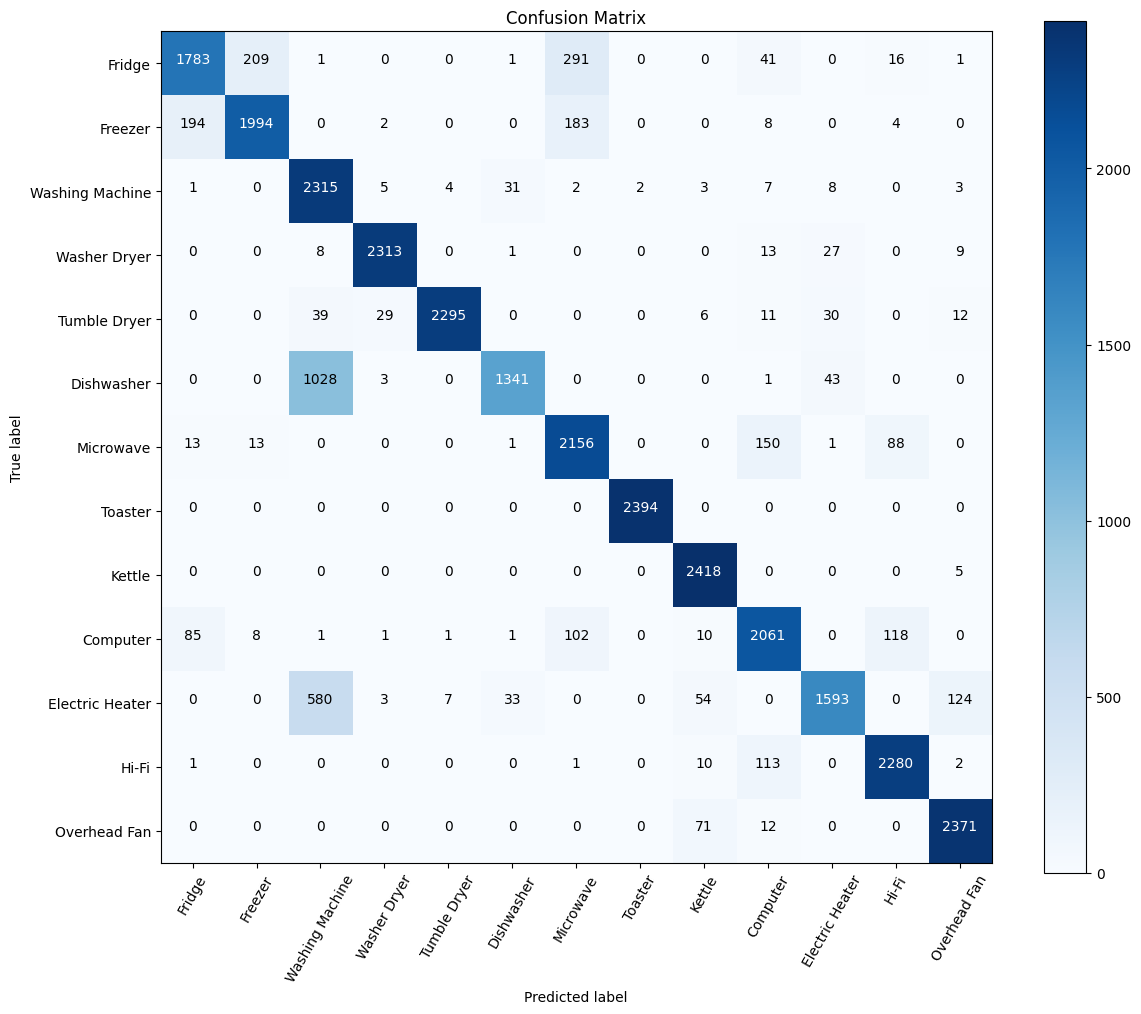

In [117]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)

In [118]:
from sklearn.metrics import classification_report 
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1),target_names=LABELS))

                 precision    recall  f1-score   support

       Computer       0.86      0.76      0.81      2343
     Dishwasher       0.90      0.84      0.87      2385
Electric Heater       0.58      0.97      0.73      2381
        Freezer       0.98      0.98      0.98      2371
         Fridge       0.99      0.95      0.97      2422
          Hi-Fi       0.95      0.56      0.70      2416
         Kettle       0.79      0.89      0.84      2422
      Microwave       1.00      1.00      1.00      2394
   Overhead Fan       0.94      1.00      0.97      2423
        Toaster       0.85      0.86      0.86      2388
   Tumble Dryer       0.94      0.67      0.78      2394
   Washer Dryer       0.91      0.95      0.93      2407
Washing Machine       0.94      0.97      0.95      2454

       accuracy                           0.88     31200
      macro avg       0.89      0.88      0.87     31200
   weighted avg       0.89      0.88      0.87     31200



In [ ]:
# from keras import ops
from keras.models import save_model

save_model(model,'GLU_CNN_LSTM_model.keras')
print('Saved model to: GLU_CNN_LSTM_model.keras')


Saved model to: GLU_CNN_LSTM_model.keras


In [87]:
WINDOW_SIZE = 300
STEP_SIZE = 275

def extract_windows(signal):
    signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
    windows = []
    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        windows.append(window)
    return windows

def prepare_inference_data(aggregate_file_path):
    X_all = []
    column_name = 'Aggregate'  # Change to 'mains' if needed

    for file_path in sorted(Path(aggregate_file_path).glob("*.csv")):
        print(f"Processing: {file_path.name}")
        df = pd.read_csv(file_path)

        # Use 'aggregate' or 'mains' column
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in {file_path.name}")

        signal = df[column_name].fillna(0).values.astype(np.float32)
        windows = extract_windows(signal)
        X_all.extend(windows)

    X_all_np = np.array(X_all)[..., np.newaxis]  # shape: (n_windows, window_size, 1)
    print(f"\nTotal windows extracted: {X_all_np.shape[0]}")
    return X_all_np


In [88]:
path = Path(f"{DATA_DIR}/Aggregate")
X_infer = prepare_inference_data(path)


Processing: Aggregate_House_1.csv_0.csv
Processing: Aggregate_House_1.csv_1.csv
Processing: Aggregate_House_1.csv_10.csv
Processing: Aggregate_House_1.csv_11.csv
Processing: Aggregate_House_1.csv_12.csv
Processing: Aggregate_House_1.csv_13.csv
Processing: Aggregate_House_1.csv_14.csv
Processing: Aggregate_House_1.csv_15.csv
Processing: Aggregate_House_1.csv_16.csv
Processing: Aggregate_House_1.csv_17.csv
Processing: Aggregate_House_1.csv_18.csv
Processing: Aggregate_House_1.csv_19.csv
Processing: Aggregate_House_1.csv_2.csv
Processing: Aggregate_House_1.csv_20.csv
Processing: Aggregate_House_1.csv_21.csv
Processing: Aggregate_House_1.csv_22.csv
Processing: Aggregate_House_1.csv_23.csv
Processing: Aggregate_House_1.csv_24.csv
Processing: Aggregate_House_1.csv_25.csv
Processing: Aggregate_House_1.csv_3.csv
Processing: Aggregate_House_1.csv_4.csv
Processing: Aggregate_House_1.csv_5.csv
Processing: Aggregate_House_1.csv_6.csv
Processing: Aggregate_House_1.csv_7.csv
Processing: Aggregate_Ho

In [6]:
from keras.models import load_model

loaded_model = load_model('GLU_CNN_LSTM_model.keras')

# predictions = loaded_model.predict(X_infer)
# predicted_classes = np.argmax(predictions, axis=1)

In [50]:
from keras.metrics import BinaryAccuracy, AUC

# loaded_model.summary()

x = loaded_model.layers[-1].input
# print(f"Shape of second-last layer output: {x.shape}")
# seq2seq = LSTM(64, return_sequences=True, name="lstm_seq")(x)
# seq2seq = TimeDistributed(Dense(13, activation='sigmoid'), name="time_distributed_output")(seq2seq)
# Compile

seq2point = Dense(13, activation='sigmoid')(x)

seq2point_model = Model(inputs=loaded_model.input, outputs=seq2point)
seq2point_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy(name='binary_accuracy'),AUC(name='auc')])

# # # Summary
seq2point_model.summary()






Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 300, 64)   │        384 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 300, 64)   │          0 │ conv1d_107[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_126        │ (None, 300, 64)   │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 300, 64)   │        128 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_108 (Conv1D) │ (None, 300, 64)   │      4,160 │ multiply_126[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 300, 64)   │          0 │ conv1d_109[0][0], │
│                     │                   │            │ conv1d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 150, 64)   │          0 │ add_108[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_111 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_110 (Conv1D) │ (None, 150, 128)  │     24,704 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 150, 128)  │          0 │ conv1d_111[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_127        │ (None, 150, 128)  │          0 │ conv1d_110[0][0], │
│ (Multiply)          │                   │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_113 (Conv1D) │ (None, 150, 128)  │      8,320 │ max_pooling1d_30… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_112 (Conv1D) │ (None, 150, 128)  │     16,512 │ multiply_127[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_109 (Add)       │ (None, 150, 128)  │          0 │ conv1d_113[0][0], │
│                     │                   │            │ conv1d_112[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 75, 128)   │          0 │ add_109[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 75, 128)   │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     49,408 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      8,320 │ lstm_13[0][0]   

 Total params: 138,701 (541.80 KB)

 Trainable params: 138,701 (541.80 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import os
import pandas as pd

NUM_SEQUENCES = 5000

def load_appliance_data(root_dir):
    appliance_data = {}

    for appliance in well_represented:
        appliance_dir = os.path.join(root_dir, appliance)
        if not os.path.isdir(appliance_dir):
            continue

        all_series = []

        for file in os.listdir(appliance_dir):
            print(f"Processing file: {file}")
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(appliance_dir, file))
                # Try to infer the power column
                # power_col = next((col for col in df.columns if appliance in col.lower()), None)
                # if power_col:
                power_col = appliance
                all_series.append(df[power_col].dropna().values)

        if all_series:
            appliance_data[appliance] = all_series
            # if len(all_series) > NUM_SEQUENCES:
            #     appliance_data[appliance] = random.sample(all_series, NUM_SEQUENCES)
    print(f"Loaded data for {len(appliance_data)} appliances.")
    return appliance_data


In [42]:
import numpy as np
import random

def create_synthetic_dataset_from_csvs(
    appliance_data,
    sequence_length=512,
    num_sequences=NUM_SEQUENCES,
    max_agg_power=6000,
    thresholds = {
    'Fridge': 10,             # Fridge usually cycles on/off, ~50W when ON
    'Freezer': 10,            # Similar to fridge, slightly less
    'Washing Machine': 20,    # Low power except during heating/spin, threshold low to catch usage
    'Washer Dryer': 30,       # Combined washing + drying power, slightly higher threshold
    'Tumble Dryer': 100,      # Generally high power, but threshold lower to detect start
    'Dishwasher': 30,         # Cycles with heater and motor, so low threshold to detect activity
    'Microwave': 10,         # High power appliance, higher threshold
    'Toaster': 150,           # Instant high power heating element
    'Kettle': 50,            # Usually 2000W+, high threshold to catch boil time
    'Computer': 20,           # Low power but constant, low threshold to detect ON state
    'Electric Heater': 50,   # High power heater, higher threshold
    'Hi-Fi': 10,              # Low power electronics, low threshold
    'Overhead Fan': 20        # Low power motor, low threshold
}
):
    appliance_names = list(appliance_data.keys())
    synthetic_X = []
    synthetic_Y = []

    for seq_idx in range(num_sequences):
        print(f"Generating sequence {seq_idx + 1}/{num_sequences}")
        agg_seq = np.zeros(sequence_length)
        appliance_power_matrix = np.zeros((sequence_length, len(appliance_names)))

        for i, appliance in enumerate(appliance_names):
            csv_list = appliance_data[appliance]
            if not csv_list:
                continue

            series = random.choice(csv_list)
            if len(series) < sequence_length:
                continue

            start = random.randint(0, len(series) - sequence_length)
            segment = series[start:start + sequence_length]

            temp_agg = agg_seq + segment
            if np.max(temp_agg) <= max_agg_power:
                agg_seq = temp_agg
                appliance_power_matrix[:, i] = segment


        synthetic_X.append(agg_seq.reshape(sequence_length, 1))

        # Output: ON/OFF at the center of the window
        midpoint = sequence_length // 2
        label_vector = []
        for i, appliance in enumerate(appliance_names):
            threshold = thresholds.get(appliance, 50)
            state = int(appliance_power_matrix[midpoint, i] > threshold)
            label_vector.append(state)

        synthetic_Y.append(label_vector)  # shape: (num_appliances,)

    return np.array(synthetic_X), np.array(synthetic_Y), appliance_names


In [43]:
appliance_data = load_appliance_data(DATA_DIR)


Processing file: Fridge_House_1.csv_0.csv
Processing file: Fridge_House_1.csv_10.csv
Processing file: Fridge_House_1.csv_100.csv
Processing file: Fridge_House_1.csv_101.csv
Processing file: Fridge_House_1.csv_102.csv
Processing file: Fridge_House_1.csv_103.csv
Processing file: Fridge_House_1.csv_104.csv
Processing file: Fridge_House_1.csv_105.csv
Processing file: Fridge_House_1.csv_106.csv
Processing file: Fridge_House_1.csv_107.csv
Processing file: Fridge_House_1.csv_108.csv
Processing file: Fridge_House_1.csv_109.csv
Processing file: Fridge_House_1.csv_110.csv
Processing file: Fridge_House_1.csv_111.csv
Processing file: Fridge_House_1.csv_112.csv
Processing file: Fridge_House_1.csv_113.csv
Processing file: Fridge_House_1.csv_114.csv
Processing file: Fridge_House_1.csv_115.csv
Processing file: Fridge_House_1.csv_116.csv
Processing file: Fridge_House_1.csv_117.csv
Processing file: Fridge_House_1.csv_118.csv
Processing file: Fridge_House_1.csv_119.csv
Processing file: Fridge_House_1.csv

In [44]:
# print(appliance_data)  # Check loaded appliances
# Create synthetic dataset
X, Y, labels = create_synthetic_dataset_from_csvs(appliance_data, sequence_length=300, num_sequences=20000)

print("X shape (aggregated):", X.shape)  # (5000, 300, 1)
print("Y shape (labels):", Y.shape)      # (5000, 300, num_appliances)
print("Appliance order:", labels)

print("Example aggregated input (first sequence):", X[0])  # Show first 10 values
print("Example aggregated input (first sequence):", Y[0])  # Show first 10 values

Generating sequence 1/20000
Generating sequence 2/20000
Generating sequence 3/20000
Generating sequence 4/20000
Generating sequence 5/20000
Generating sequence 6/20000
Generating sequence 7/20000
Generating sequence 8/20000
Generating sequence 9/20000
Generating sequence 10/20000
Generating sequence 11/20000
Generating sequence 12/20000
Generating sequence 13/20000
Generating sequence 14/20000
Generating sequence 15/20000
Generating sequence 16/20000
Generating sequence 17/20000
Generating sequence 18/20000
Generating sequence 19/20000
Generating sequence 20/20000
Generating sequence 21/20000
Generating sequence 22/20000
Generating sequence 23/20000
Generating sequence 24/20000
Generating sequence 25/20000
Generating sequence 26/20000
Generating sequence 27/20000
Generating sequence 28/20000
Generating sequence 29/20000
Generating sequence 30/20000
Generating sequence 31/20000
Generating sequence 32/20000
Generating sequence 33/20000
Generating sequence 34/20000
Generating sequence 35/

In [57]:
print(f"Generated {len(X)} sequences with shape {X.shape} and labels shape {Y.shape}")
history = seq2point_model.fit(X, Y, epochs=5, batch_size=10, validation_split=0.1)

Generated 20000 sequences with shape (20000, 300, 1) and labels shape (20000, 13)
Epoch 1/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - auc: 0.7810 - binary_accuracy: 0.7293 - loss: 0.5067 - val_auc: 0.7819 - val_binary_accuracy: 0.7310 - val_loss: 0.5065
Epoch 2/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - auc: 0.7793 - binary_accuracy: 0.7289 - loss: 0.5085 - val_auc: 0.7813 - val_binary_accuracy: 0.7303 - val_loss: 0.5069
Epoch 3/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - auc: 0.7799 - binary_accuracy: 0.7302 - loss: 0.5075 - val_auc: 0.7843 - val_binary_accuracy: 0.7299 - val_loss: 0.5051
Epoch 4/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - auc: 0.7823 - binary_accuracy: 0.7293 - loss: 0.5068 - val_auc: 0.7820 - val_binary_accuracy: 0.7314 - val_loss: 0.5065
Epoch 5/5
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - auc: 0.7823 - binary_accuracy: 0.7311 - loss: 0.5059 - val_auc: 0.7815 - val_binary_accuracy: 0.7308 - val_loss: 0.5063


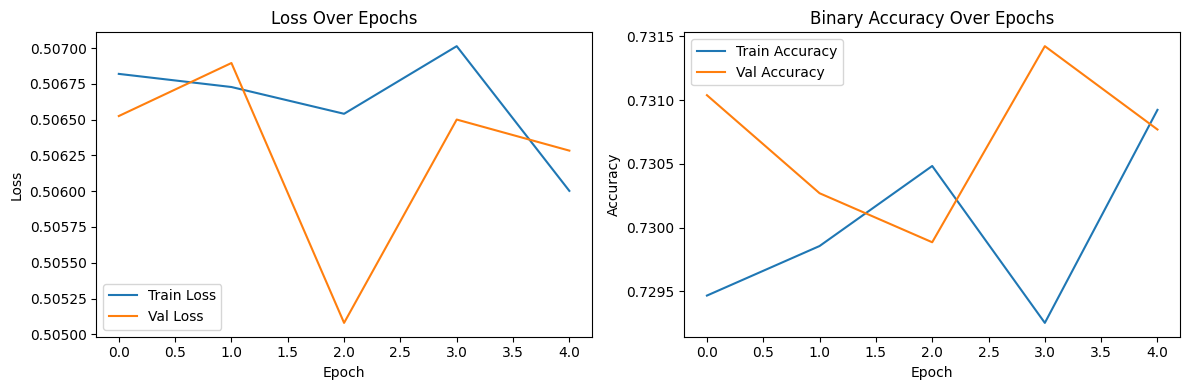

In [58]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Predict on test data
preds = model.predict(X_test)

# Threshold predictions to 0/1 (optional: use different threshold)
preds_binary = (preds > 0.5).astype(int)

# Choose an example sequence (e.g., index 10)
idx = 10
plt.figure(figsize=(15, 4))
for i in range(preds.shape[1]):  # one plot per appliance
    plt.subplot(3, 5, i+1)
    plt.plot(Y_test[idx, :, i], label='True', linestyle='-')
    plt.plot(preds_binary[idx, :, i], label='Pred', linestyle='--')
    plt.title(f'Appliance {i}')
    plt.ylim(-0.1, 1.1)
    plt.legend()

plt.tight_layout()
plt.show()
